In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import json
import os
import numpy as np
import glob
from modelzipper.tutils import *
from matplotlib.colors import ListedColormap, BoundaryNorm

/data/anaconda3/envs/zecheng/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModelZipper is ready for launch🚀 | Current Version🦄 >>> 0.2.7 <<< | AOE Time🕒 2024-12-02 14:20:43


In [3]:
head_reasoning_file = "/data/zecheng/acl2025/MyRLHF/RetrievalHead/reetrievalheaddetect/head_score/q3_inf_diff_pos/Meta-Llama-3.1-8B-Instruct.json"
head_score_file = "/data/zecheng/acl2025/MyRLHF/RetrievalHead/reetrievalheaddetect/head_score/niah_retrieval/Meta-Llama-3.1-8B-Instruct.json"
reason_scores = auto_read_data(head_reasoning_file)
retrieval_scores = auto_read_data(head_score_file)

begin to read data from /data/zecheng/acl2025/MyRLHF/RetrievalHead/reetrievalheaddetect/head_score/q3_inf_diff_pos/Meta-Llama-3.1-8B-Instruct.json | file size: 3.33 MB | file type: json
begin to read data from /data/zecheng/acl2025/MyRLHF/RetrievalHead/reetrievalheaddetect/head_score/niah_retrieval/Meta-Llama-3.1-8B-Instruct.json | file size: 1.46 MB | file type: json


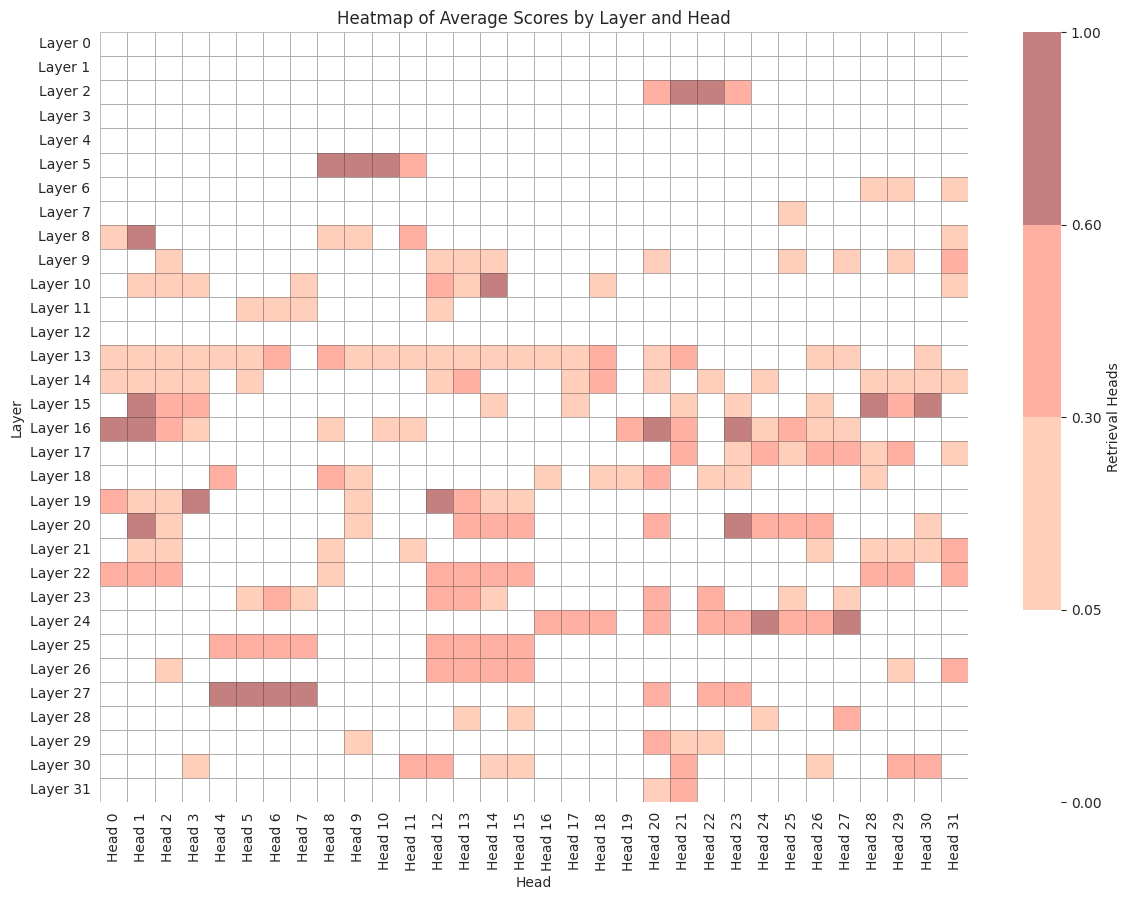

In [4]:
num_layers = 32
num_heads = 32
df_reason_scores = np.zeros((num_layers, num_heads))
df_retrieval_scores = np.zeros((num_layers, num_heads))

for key, values in reason_scores.items():
    layer, head = map(int, key.split('-'))
    df_reason_scores[layer, head] = np.mean(values)

for key, values in retrieval_scores.items():
    layer, head = map(int, key.split('-'))
    df_retrieval_scores[layer, head] = np.mean(values)

colors1 = ['#ffffff', '#90ee90', '#32cd32', '#006400']  # 浅绿 -> 中绿 -> 深绿
colors2 = ['#ffffff', '#ffa07a', '#ff6347', '#8b0000']  # 浅红 -> 中红 -> 深红
bounds = [0, 0.05, 0.3, 0.6, 1.0]  # 定义边界

# 创建colormap和norm
cmap1 = ListedColormap(colors1)
cmap2 = ListedColormap(colors2)
norm = BoundaryNorm(bounds, len(colors1))

# 转换为 DataFrame
df_reason_scores = pd.DataFrame(df_reason_scores, columns=[f'Head {i}' for i in range(num_heads)], 
                  index=[f'Layer {i}' for i in range(num_layers)])
df_retrieval_scores = pd.DataFrame(df_retrieval_scores, columns=[f'Head {i}' for i in range(num_heads)], 
                  index=[f'Layer {i}' for i in range(num_layers)])

sns.set_style("white")

reasoning_heads = df_reason_scores > 0.1
retrieval_heads = df_retrieval_scores > 0.1

# 绘制热力图
plt.figure(figsize=(14, 10))

# sns.heatmap(df_reason_scores, cmap=cmap1, norm=norm, alpha=1, cbar=True, 
#             cbar_kws={'label': 'Reasoning Heads'}, linewidths=0.5, linecolor='gray')

sns.heatmap(df_retrieval_scores, cmap=cmap2, norm=norm, alpha=0.5, cbar=True, 
            cbar_kws={'label': 'Retrieval Heads'}, linewidths=0.5, linecolor='gray')

plt.title('Heatmap of Average Scores by Layer and Head')
plt.xlabel('Head')
plt.ylabel('Layer')
plt.show()

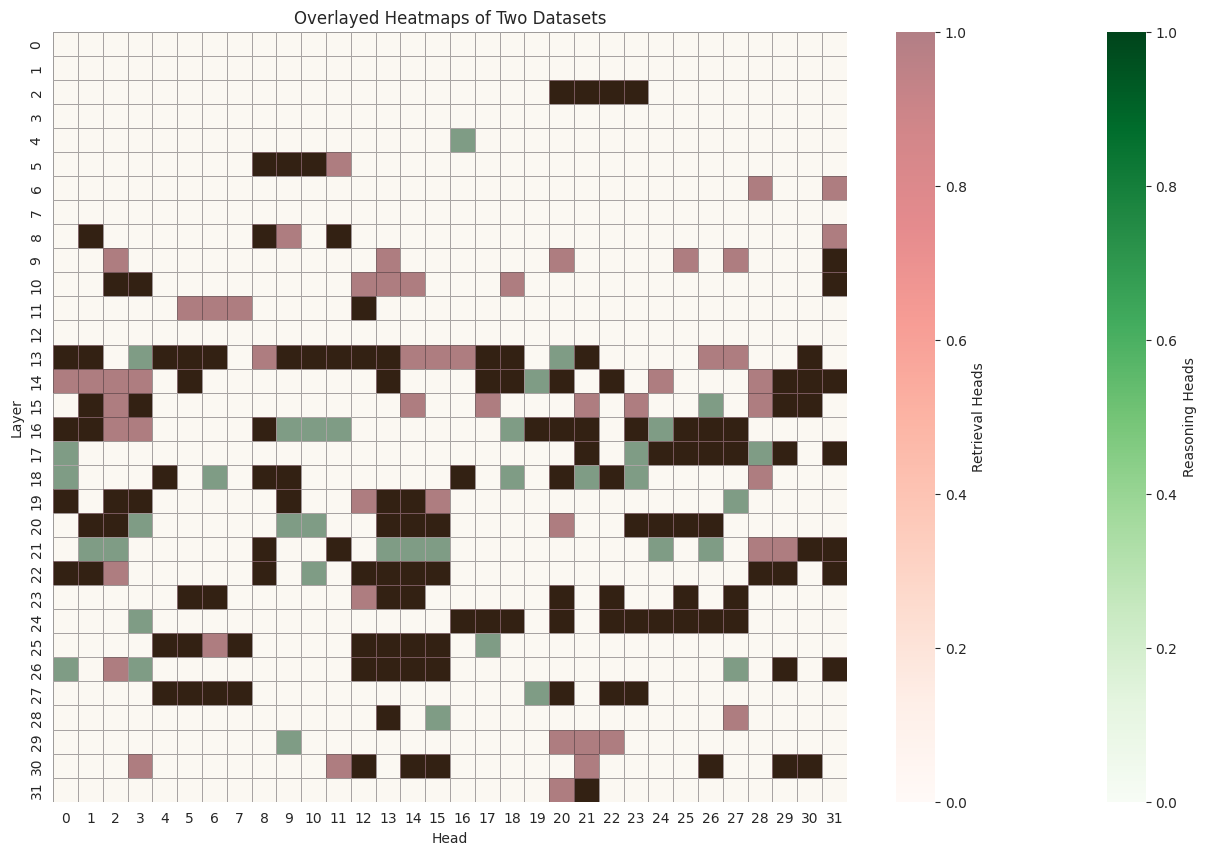

In [5]:
num_layers = 32
num_heads = 32
df_reason_scores = np.zeros((num_layers, num_heads))
df_retrieval_scores = np.zeros((num_layers, num_heads))

for key, values in reason_scores.items():
    layer, head = map(int, key.split('-'))
    df_reason_scores[layer, head] = np.mean(values)

for key, values in retrieval_scores.items():
    layer, head = map(int, key.split('-'))
    df_retrieval_scores[layer, head] = np.mean(values)

reasoning_heads = df_reason_scores > 0.1
retrieval_heads = df_retrieval_scores > 0.1

plt.figure(figsize=(16, 10))
sns.heatmap(reasoning_heads, cmap='Greens', alpha=1, cbar=True, 
            cbar_kws={'label': 'Reasoning Heads'}, linewidths=0.5, linecolor='gray')
sns.heatmap(retrieval_heads, cmap='Reds', alpha=0.5, cbar=True, 
            cbar_kws={'label': 'Retrieval Heads'}, linewidths=0.5, linecolor='gray')

plt.title('Overlayed Heatmaps of Two Datasets')
plt.xlabel('Head')
plt.ylabel('Layer')

plt.show()
